Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [2]:
data = pd.read_csv('C:/Users/maslo/Desktop/karpov_start_ml/2_module/4_lesson/materials/data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [3]:
len(data)

1000

In [3]:
from sklearn.linear_model import LinearRegression

X = data.drop(['target'], axis=1)
Y = data['target']

model=LinearRegression()
model.fit(X, Y)

LinearRegression()

In [4]:
model.coef_, model.intercept_

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 4.373157038707092)

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [ ]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y).values

In [6]:
initial_betas = np.ones(X.shape[1])

In [7]:
initial_betas

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
initial_betas.reshape(-1, 1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [9]:
np.dot(X, initial_betas.reshape(-1, 1))

array([[4.24339854],
       [3.9524118 ],
       [5.16354431],
       [5.05108987],
       [3.70336585],
       [5.97562576],
       [5.36645618],
       [4.64371227],
       [5.31215445],
       [5.13559383],
       [4.57902419],
       [4.32294422],
       [5.54997113],
       [3.38646272],
       [5.46648432],
       [4.15761811],
       [4.54622922],
       [4.92460189],
       [5.49512761],
       [4.20534235],
       [3.79440676],
       [3.64754149],
       [3.3861493 ],
       [5.28347287],
       [4.63170572],
       [3.82066088],
       [5.70447535],
       [5.00305454],
       [5.18649487],
       [4.32348734],
       [5.37919592],
       [5.30162516],
       [4.73808802],
       [4.58758426],
       [5.64623264],
       [3.92151158],
       [5.52622189],
       [4.56147026],
       [3.64504638],
       [5.78092671],
       [4.37963386],
       [3.73847398],
       [4.56174807],
       [5.42891712],
       [5.33241798],
       [4.92249654],
       [4.00705898],
       [4.961

In [10]:
np.dot(X, initial_betas.reshape(-1, 1)).ravel()

array([4.24339854, 3.9524118 , 5.16354431, 5.05108987, 3.70336585,
       5.97562576, 5.36645618, 4.64371227, 5.31215445, 5.13559383,
       4.57902419, 4.32294422, 5.54997113, 3.38646272, 5.46648432,
       4.15761811, 4.54622922, 4.92460189, 5.49512761, 4.20534235,
       3.79440676, 3.64754149, 3.3861493 , 5.28347287, 4.63170572,
       3.82066088, 5.70447535, 5.00305454, 5.18649487, 4.32348734,
       5.37919592, 5.30162516, 4.73808802, 4.58758426, 5.64623264,
       3.92151158, 5.52622189, 4.56147026, 3.64504638, 5.78092671,
       4.37963386, 3.73847398, 4.56174807, 5.42891712, 5.33241798,
       4.92249654, 4.00705898, 4.96133463, 4.00952333, 3.54853568,
       5.57722518, 3.6827849 , 4.36082279, 5.8455649 , 4.66986831,
       6.65566972, 4.363927  , 3.24811339, 4.12653761, 4.29553237,
       4.10798391, 4.87482995, 5.62744705, 4.99671407, 4.75811197,
       4.45837844, 6.02034933, 2.88183343, 4.30169734, 6.13075889,
       6.25145428, 5.46300566, 5.09670393, 3.39861176, 4.45886

In [11]:
scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()

In [13]:
scalar_value = (scalar_value - Y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [ ]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [17]:
d_i1 = X.values[:, 0]

In [18]:
d_i1

array([1.13768107e-01, 3.80048040e-01, 7.68461926e-01, 6.06636831e-01,
       1.19769781e-01, 7.09440561e-01, 3.51070785e-01, 4.07922933e-01,
       9.09109388e-01, 8.97732978e-01, 1.14523274e-01, 4.03444426e-01,
       7.03064154e-01, 4.35740645e-01, 8.67445323e-01, 9.72333590e-01,
       3.40524070e-01, 2.43060008e-01, 9.20653927e-01, 6.09519384e-01,
       6.12201542e-01, 9.47261045e-01, 6.93469199e-01, 9.31654329e-01,
       3.65458067e-01, 6.57138773e-02, 2.19818774e-01, 6.31288910e-01,
       6.68181416e-01, 8.33952273e-01, 8.34089419e-01, 7.08499500e-01,
       3.14640327e-01, 8.48615480e-01, 1.77080539e-01, 8.31700751e-01,
       8.02500274e-01, 5.75984316e-01, 1.69205432e-01, 7.39388183e-01,
       9.50438497e-01, 8.72836718e-01, 4.46394800e-01, 5.21557007e-01,
       5.02629977e-01, 8.45786923e-01, 4.16636310e-01, 7.73042667e-01,
       6.55457633e-01, 4.74001251e-03, 7.19046697e-01, 8.76527633e-02,
       3.53890886e-01, 7.86006553e-01, 9.24538993e-01, 3.89290872e-01,
      

In [19]:
scalar_value = scalar_value * d_i1

In [20]:
scalar_value

array([-2.94701446e+00, -6.64019582e+00, -2.01786666e+01, -1.59287653e+01,
       -2.34980948e+00, -2.03194721e+01, -9.99934717e+00, -1.02551234e+01,
       -2.01637786e+01, -2.22452912e+01, -2.92332565e+00, -9.62102324e+00,
       -2.14726754e+01, -7.22352557e+00, -2.32184311e+01, -1.86869802e+01,
       -9.49272206e+00, -5.79998011e+00, -2.45036007e+01, -1.53571918e+01,
       -1.38025119e+01, -1.79256163e+01, -1.07751724e+01, -2.34582155e+01,
       -8.59402054e+00, -1.50341602e+00, -7.59897339e+00, -1.73338324e+01,
       -1.47823690e+01, -1.82282109e+01, -2.37397306e+01, -1.77200609e+01,
       -7.48109339e+00, -1.94714931e+01, -5.93336039e+00, -1.52395908e+01,
       -2.36684262e+01, -1.51446737e+01, -3.62368048e+00, -1.87835317e+01,
       -2.27634091e+01, -2.00185071e+01, -1.24489460e+01, -1.29312241e+01,
       -1.43412565e+01, -2.15082136e+01, -8.33106207e+00, -1.57505967e+01,
       -1.36008610e+01, -8.74275066e-02, -1.81923254e+01, -2.27274501e+00,
       -8.24339269e+00, -

In [21]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

In [25]:
X.values.shape

(1000, 10)

In [27]:
a = np.array([1,1])

In [31]:
(a**2).sum() ** 0.5

1.4142135623730951

In [19]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, 
                 samples: pd.DataFrame, 
                 targets: pd.DataFrame,
                 learning_rate: float = 1e-3, 
                 threshold = 1e-6, 
                 copy: bool = True
                ):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        self.copy = copy
        if self.copy:
            self.samples = samples.values.copy()
        else:
            self.samples = samples.values
        self.targets = targets.values
        self.beta = np.ones(self.samples.shape[1])
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.iteration_loss_dict = {}
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        self.samples = np.insert(self.samples, self.samples.shape[1], 1, axis=1)
        self.beta = np.ones(self.samples.shape[1])
            
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        scalar_value = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        scalar_value = (scalar_value - self.targets)
        mse = (scalar_value ** 2).mean()
        return mse

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        scalar_value = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        scalar_value = (scalar_value - self.targets)
        grad = []
        for i in range(self.samples.shape[1]):
            d_i1 = self.samples[:, i]
            tmp_scalar_value = scalar_value * d_i1
            grad.append(2 * np.mean(tmp_scalar_value))
        return np.array(grad)
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        self.beta = self.beta - self.learning_rate * self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| > threshold:
                Повторяем первые 3 шага
                
        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| > threshold:
                Повторяем первые 3 шага
        """
        iter_ = 0
        current_beta = self.beta
        new_beta = np.array([0 for i in range(self.beta.shape[0])])
        while ((((current_beta - new_beta)**2).sum()) ** 0.5) > self.threshold:
            current_beta = self.beta
            self.iteration()
            new_beta = self.beta
            self.iteration_loss_dict[iter_] = self.calculate_mse_loss()
            iter_ += 1

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [20]:
%%time
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [21]:
print('Веса модели при переменных d1, d2, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d1, d2, ..., d10 равны соответственно: 

[0.99622943 1.99685888 2.99612266 3.99604866 4.99670765 5.99661395
 6.99669112 7.99703763 8.99614439 9.99564766 4.39136559]


In [17]:
len(GD.iteration_loss_dict)

116030

In [18]:
GD.iteration_loss_dict[116030-1]

1.0747710429990302e-05

Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [6]:
GD = GradientDescentMse(samples=X, targets=Y, learning_rate=0.5)
GD.add_constant_feature()
GD.learn()

C:\Users\maslo\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: overflow encountered in square
C:\Users\maslo\Anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\maslo\Anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\maslo\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in subtract


In [7]:
GD = GradientDescentMse(samples=X, targets=Y, threshold=0.5)
GD.add_constant_feature()
GD.learn()

In [8]:
print('Веса модели при переменных d1, d2, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d1, d2, ..., d10 равны соответственно: 

[1.0265892  1.02604062 1.02462436 1.02494476 1.02568745 1.0269917
 1.02643473 1.0275583  1.02644021 1.0268057  1.0513514 ]


В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


In [38]:
list(GD.iteration_loss_dict.values())

[66.29428794512202,
 12.285543687283658,
 7.360307262030454,
 6.725667719485599,
 6.472428617648121,
 6.2592048334996795,
 6.055972121205659,
 5.85988587830134,
 5.670481195178852,
 5.487508363255402,
 5.310743723201238,
 5.139972904540864,
 4.974989118226218,
 4.81559277140636,
 4.661591205848316,
 4.512798455125431,
 4.369035011140521,
 4.230127598890611,
 4.0959089591173505,
 3.9662176385606935,
 3.840897787548684,
 3.719798964665996,
 3.6027759482530506,
 3.489688554496179,
 3.3804014618777574,
 3.274784041763375,
 3.172710194910875,
 3.0740581936937397,
 2.978710529838513,
 2.8865537674830666,
 2.7974784013692062,
 2.7113787199897788,
 2.6281526735166536,
 2.5477017463421125,
 2.46993083407206,
 2.394748124815091,
 2.322064984617009,
 2.2517958468955768,
 2.183858105735474,
 2.118172012908259,
 2.054660578486965,
 1.9932494749294634,
 1.9338669445091878,
 1.8764437099760676,
 1.8209128883346148,
 1.7672099076300813,
 1.7152724266374393,
 1.6650402573516296,
 1.6164552901810576,
 1

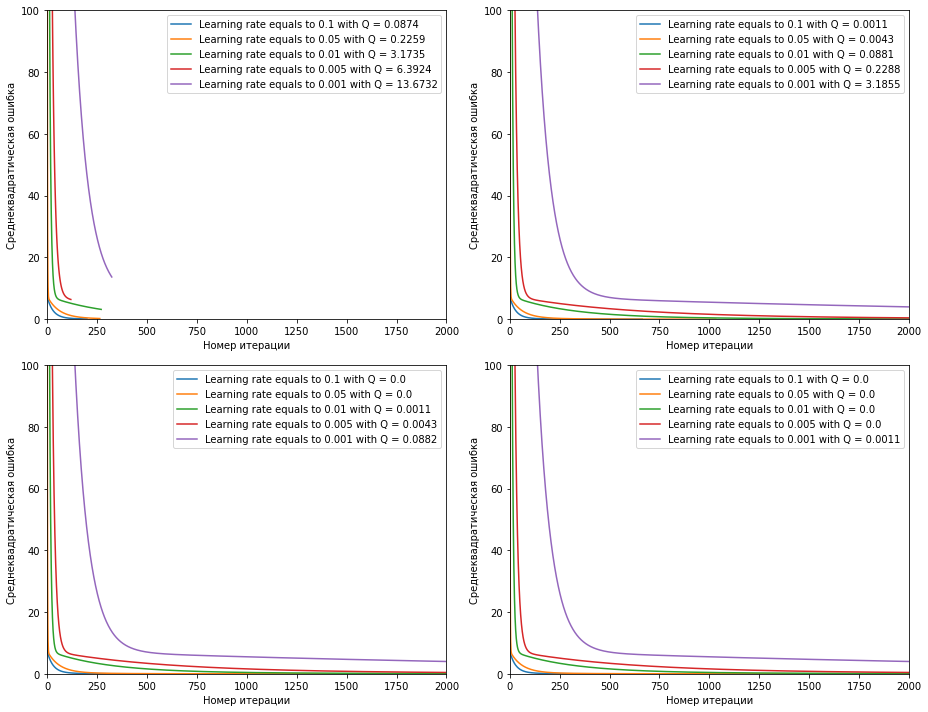

In [40]:
fig = plt.figure()

fig.set_size_inches(13, 10)

"""Задать списки для итераций"""
thresholds = [1e-2, 1e-3, 1e-4, 1e-5]
rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
graph_count = 1
for i in range(len(thresholds)):
    """Задать threshold, добавить график на полонто, создать список для хранения значений функционала"""
    threshold = thresholds[i]
    fig.add_subplot(2, 2, graph_count)
    Q_values = []
    
    for lr in rates:
        """Создать объект модели, добавить константу, запустить обучение модели"""
        GD = GradientDescentMse(samples=X, targets=Y, threshold=threshold, learning_rate=lr)
        GD.add_constant_feature()
        GD.learn()
        
        """Определить learning_path через атрибут iteration_loss_dict"""
        learning_path = GD.iteration_loss_dict
        
        """Отобразить learning_path на графике"""
        plt.plot(list(learning_path.values()))
        plt.ylim(0, 100)
        plt.xlim(0, 2000)
        
        Q_values.append(str(round(list(learning_path.values())[-1], ndigits=4)))
    
    plt.ylabel('Среднеквадратическая ошибка')
    plt.xlabel('Номер итерации')
    plt.legend([f'Learning rate equals to {rates[i]}' + ' with Q = ' + Q_values[i] for i in range(len(rates))])
    
    graph_count += 1

fig.tight_layout() 

plt.show()

In [41]:
GD = GradientDescentMse(samples=X, targets=Y, threshold=1e-4, learning_rate=0.1)
GD.add_constant_feature()
GD.learn()

In [44]:
GD.calculate_mse_loss(), len(GD.iteration_loss_dict)

(1.061091469992647e-05, 1159)

In [45]:
GD = GradientDescentMse(samples=X, targets=Y, threshold=1e-4, learning_rate=0.05)
GD.add_constant_feature()
GD.learn()

In [46]:
GD.calculate_mse_loss(), len(GD.iteration_loss_dict)

(4.2645530002200326e-05, 2022)

In [47]:
GD = GradientDescentMse(samples=X, targets=Y, threshold=1e-5, learning_rate=0.1)
GD.add_constant_feature()
GD.learn()

In [48]:
GD.calculate_mse_loss(), len(GD.iteration_loss_dict)

(1.0598014397933829e-07, 1653)